In [1]:
import pandas as pd 

data = pd.read_csv("./housing-data.csv")
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,price
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [2]:
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
price      0
dtype: int64

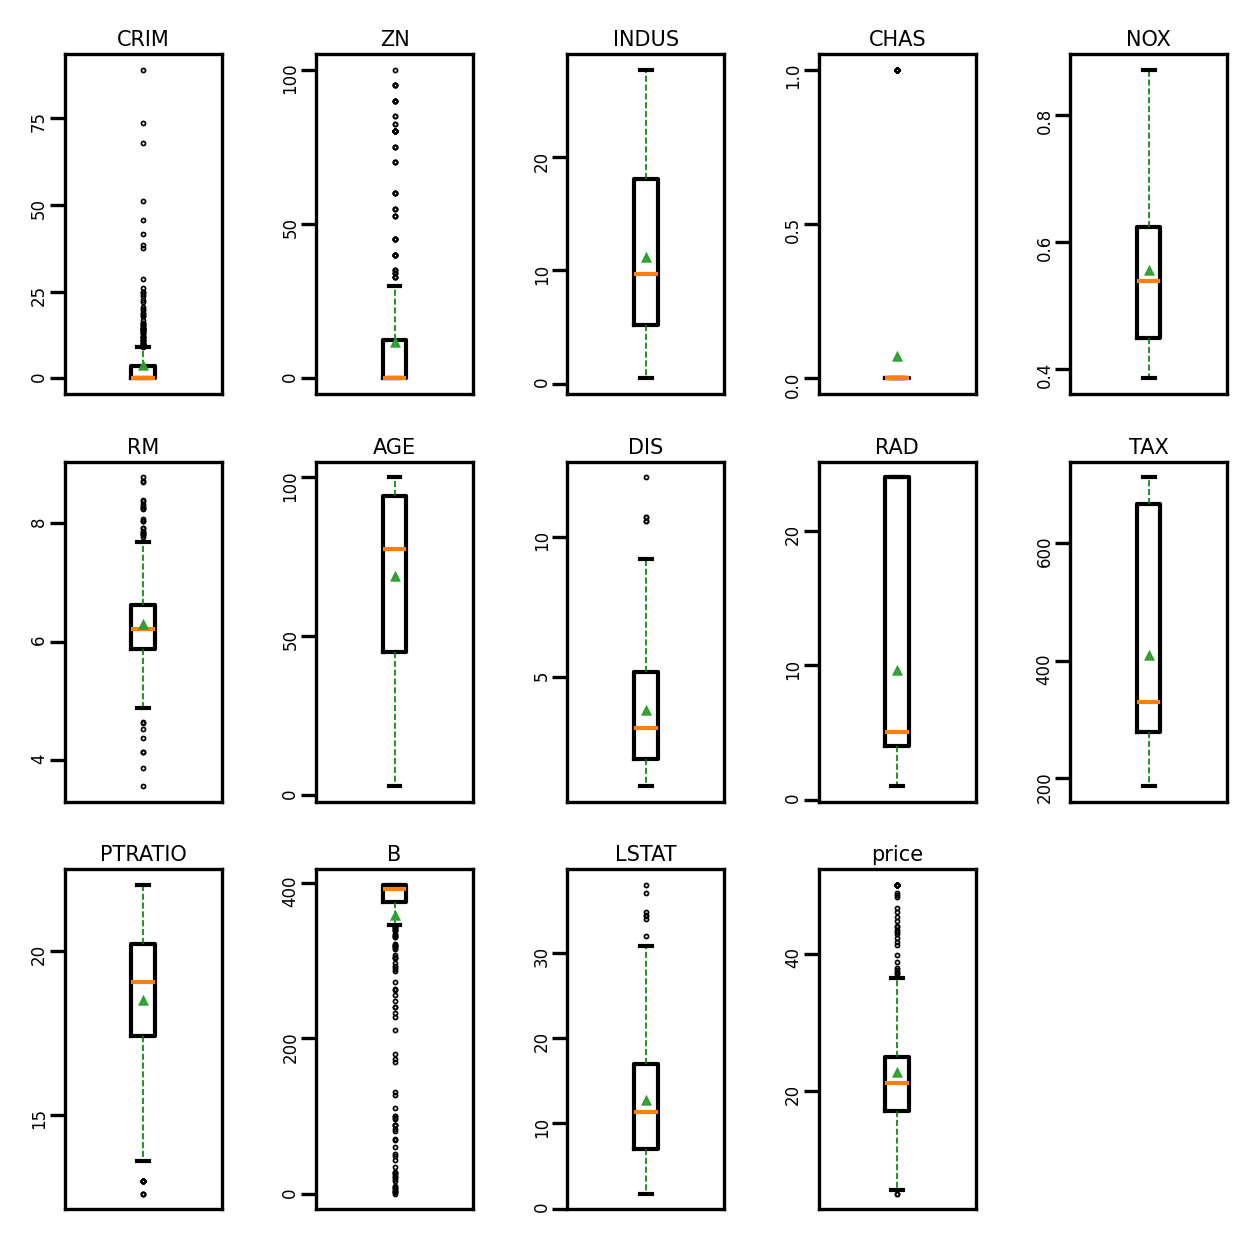

In [3]:
import matplotlib.pyplot as plt

def boxplot(data):
    data_col = list(data.columns)

    plt.figure(figsize=(5, 5), dpi=300)
    plt.subplots_adjust(wspace=0.6)
    for i, col_name in enumerate(data_col):
        plt.subplot(3, 5, i+1)
        plt.boxplot(data[col_name],
        showmeans=True,
        whiskerprops={"color":"g", "linewidth":0.4, "linestyle":"--"},
        flierprops={"markersize":0.4},
        meanprops={"markersize":1})
        plt.title(col_name, fontdict={"size":5}, pad=2)
        plt.yticks(fontsize=4, rotation=90)
        plt.tick_params(pad=0.5)
        plt.xticks([])
    plt.show()

boxplot(data)

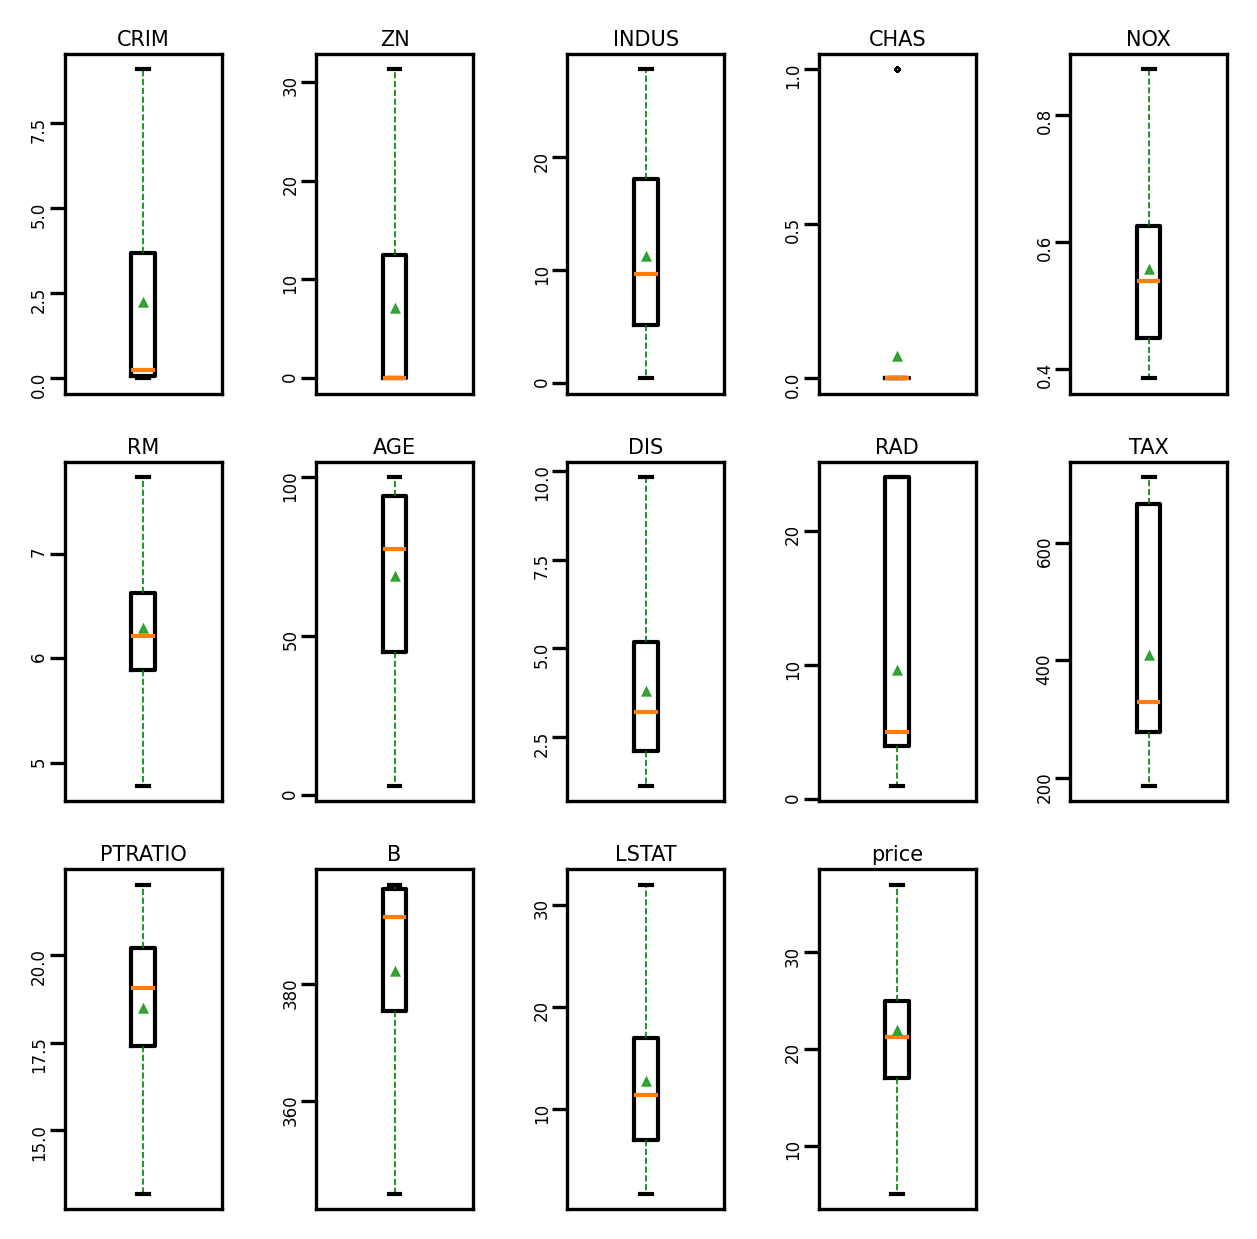

In [4]:
num_features = data.select_dtypes(exclude=['object','bool']).columns.tolist()

for feature in num_features:
    if feature == 'CHAS':
        continue

    Q1 = data[feature].quantile(q=0.25)
    Q3 = data[feature].quantile(q=0.75)
    # 利用临界值替代异常值
    IQR = Q3-Q1
    top = Q3+1.5*IQR
    bot = Q1-1.5*IQR
    values = data[feature].values
    values[values>top]=top
    values[values<bot]=bot
    data[feature] = values.astype(data[feature].dtypes)

boxplot(data)

In [5]:
import paddle

paddle.seed(10)

def train_test_split(X, y, train_percent=0.8):
    n = len(X)
    shuffled_indices = paddle.randperm(n)
    train_set_size = int(n*train_percent) 
    train_indices = shuffled_indices[:train_set_size]
    test_indices = shuffled_indices[train_set_size:]

    X = X.values
    y = y.values

    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

X = data.drop(['price'], axis=1) 
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

W0607 15:49:19.636201 176033 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0607 15:49:19.638033 176033 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


X_train:  (404, 13)
X_test:  (102, 13)
y_train:  (404,)
y_test:  (102,)


In [6]:
X_train = paddle.to_tensor(X_train, dtype="float32")
X_test = paddle.to_tensor(X_test, dtype="float32")
y_train = paddle.to_tensor(y_train, dtype="float32")
y_test = paddle.to_tensor(y_test, dtype="float32")

X_min = paddle.min(X_train, axis=0)
X_max = paddle.min(X_train, axis=0)
# 特征归一化
X_train = (X_train - X_min)/(X_max - X_min)
X_test = (X_test-X_min)/(X_max-X_min)
train_dataset = (X_train, y_train)
test_dataset = (X_test, y_test)

In [7]:
from op import Linear 
input_size = 13
model = Linear(input_size)

In [8]:
import paddle
import os

class RunnerV1(object):
    def __init__(self, model, optimizer, loss_fn, metric):
        self.model = model
        self.metric = metric
        self.optimizer = optimizer

    def train(self, dataset, reg_lambda, model_dir):
        X,y = dataset
        self.optimizer(self.model, X, y, reg_lambda)
        self.save_model(model_dir)

    def evaluate(self, dataset, **kwargs):
        X, y = dataset
        y_pred = self.model(X)
        result = self.metric(y_pred, y)
        return result

    def predict(self, X, **kwargs):
        return self.model(X)

    def save_model(self, model_dir):
        if not os.path.exists(model_dir):
            os.makedirs(model_dir) 
        params_saved_path = os.path.join(model_dir, 'params.pdtensor')
        paddle.save(model.params, params_saved_path)

    def load_model(self, model_dir):
        params_saved_path = os.path.join(model_dir, 'params.pdtensor')
        self.model.params = paddle.load(params_saved_path)

In [9]:
def optimizer_lsm(model, X, y, reg_lambda=0):
    N, D = X.shape
    x_bar_tran = paddle.mean(X, axis=0).T
    y_bar = paddle.mean(y)
    x_sub = paddle.subtract(X, x_bar_tran)
    if paddle.all(x_sub==0):
        model.params['b'] = y_bar
        model.params['w'] = paddle.zeros(shape=[D])
        return model
    tmp = paddle.inverse(paddle.matmul(x_sub.T, x_sub)+reg_lambda*paddle.eye(num_rows=(D)))
    w = paddle.matmul(paddle.matmul(tmp,x_sub.T), (y-y_bar))
    b = y_bar - paddle.matmul(x_bar_tran, w)
    model.params['b'] = b
    model.params['w'] = paddle.squeeze(w, axis=-1)
    return model

In [10]:
import paddle.nn as nn 

optimizer = optimizer_lsm
mse_loss = nn.MSELoss()
# 实例化Runner
runner = RunnerV1(model, optimizer=optimizer,loss_fn=None, metric=mse_loss)
runner.train(train_dataset, reg_lambda=0, model_dir="./checkpoint")

RuntimeError: (PreconditionNotMet) For batch [0]: CUSolver SVD is not zero. [14]
  [Hint: Expected error_info == 0, but received error_info:14 != 0:0.] (at /paddle/paddle/phi/kernels/gpu/svd_kernel.cu:117)
